## Advisory 
### If you have not yet begun the project 
Please do not use this workspace.  Use the AWS resources provided and the instructions from the [cloud computing lesson](https://classroom.udacity.com/nanodegrees/nd101/parts/b9c4c3c3-b524-427b-8832-9d0748f14a2e/modules/de12f7bf-d980-4998-ab91-0e411184c878/lessons/29df00d8-01c2-4995-92fa-a4afd020be90/concepts/80d2ed46-1bba-413e-891e-610259017251).
### If you have started on this workspace
Please consider downloading your Jupyter notebook and then following the instructions above on using AWS instead.  You can upload your current work to AWS through your GitHub account.  


As a reminder, the project can be found on the [deep learning GitHub page](https://github.com/udacity/deep-learning/tree/master/face_generation).
These warnings are given because the project frequently generates more data than the workspace can handle, causing loading problems and lost work.  Please use [the forums](https://discussions.udacity.com/c/nd101-part-5-GANs/nd101-generate-faces) if you have any questions on the project or its setup.


# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
!pip install -U matplotlib==2.2.2

    100% |████████████████████████████████| 12.6MB 55kB/s  eta 0:00:01
Requirement already up-to-date: six>=1.10 in /opt/conda/lib/python3.6/site-packages (from matplotlib==2.2.2)
Requirement already up-to-date: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /opt/conda/lib/python3.6/site-packages (from matplotlib==2.2.2)
    100% |████████████████████████████████| 512kB 1.5MB/s eta 0:00:01
    100% |████████████████████████████████| 215kB 3.3MB/s eta 0:00:01
    100% |████████████████████████████████| 12.2MB 57kB/s  eta 0:00:01
    100% |████████████████████████████████| 952kB 765kB/s eta 0:00:01
Requirement already up-to-date: cycler>=0.10 in /opt/conda/lib/python3.6/site-packages/cycler-0.10.0-py3.6.egg (from matplotlib==2.2.2)
    100% |████████████████████████████████| 573kB 1.2MB/s eta 0:00:01
  Found existing installation: pytz 2017.3
    Uninstalling pytz-2017.3:
      Successfully uninstalled pytz-2017.3
  Found existing installation: python-dateutil 2.6.1
    Uninstalling python-

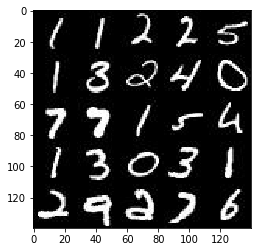

In [11]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

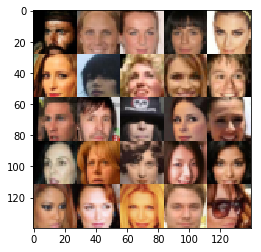

In [12]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [14]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,(None, z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        lay1 = tf.layers.conv2d(images, 128, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha*lay1,lay1)
        
        lay2 = tf.layers.conv2d(relu1, 256, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(lay2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        lay3 = tf.layers.conv2d(relu2, 512, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(lay3, training=True)
        relu3 = tf.maximum(alpha*bn3,bn3)
        
        
        flat = tf.reshape(lay3, (-1, 512*4*4))
        logits = tf.layers.dense(flat, 1)
        
        logits = tf.layers.dropout(logits, rate=0.3)
       
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not(is_train)):
        lay1 = tf.layers.dense(z, 7*7*512)
        lay1 = tf.reshape(lay1, (-1,7,7,512))
        lay1 = tf.layers.batch_normalization(lay1, training = is_train)
        lay1 = tf.maximum(alpha*lay1, lay1)
        
        lay2 = tf.layers.conv2d_transpose(lay1, 256, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        lay2 = tf.layers.batch_normalization(lay2, training = is_train)
        lay2 = tf.maximum(alpha*lay2, lay2)
        
        
        lay3 = tf.layers.conv2d_transpose(lay2, 128, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        lay3 = tf.layers.batch_normalization(lay3, training = is_train)
        lay3 = tf.maximum(alpha*lay3, lay3)
        
               
        lay4 = tf.layers.conv2d_transpose(lay3, 56, 5, 1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        lay4 = tf.layers.batch_normalization(lay4, training = is_train)
        lay4 = tf.maximum(alpha*lay4, lay4)
        
        
        
        lay4 = tf.layers.conv2d_transpose(lay4, out_channel_dim, 5, 1, padding='same')
        lay4 = tf.layers.dropout(lay4, rate=0.1)

        output = tf.tanh(lay4)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [20]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_output_real, d_logits_real = discriminator(input_real)
    d_output_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real, \
                                                                         labels = tf.ones_like(d_logits_real)*np.random.uniform(0.7, 1.2)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, \
                                                                         labels = tf.zeros_like(d_logits_fake)*np.random.uniform(0.0, 0.3)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake, \
                                                                    labels = tf.ones_like(d_logits_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [19]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables = tf.trainable_variables()
    
    d_var = [var for var in variables if var.name.startswith('discriminator')]
    g_var = [var for var in variables if var.name.startswith('generator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list = d_var)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list = g_var)
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [18]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [21]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_, image_width, image_height, image_channel = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channel, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channel)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    
    step = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images*2
                step += 1
                batch_z = np.random.uniform(-1,1,(batch_size, z_dim))
                _=sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, learn_rate:learning_rate})
                _=sess.run(g_opt, feed_dict={input_real:batch_images, input_z:batch_z, learn_rate:learning_rate})
                if step % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z:batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print ('Epoch {}/{}'.format(epoch_i+1, epoch_count),
                           'Discriminator Loss{:.4f}'.format(train_loss_d),
                           'Generator Loss{:.4f}'.format(train_loss_g))
                if step % 100 == 0:
                    show_generator_output(sess, batch_size, input_z, image_channel, data_image_mode) 
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Discriminator Loss0.3543 Generator Loss2.1449
Epoch 1/2 Discriminator Loss0.1978 Generator Loss4.5797
Epoch 1/2 Discriminator Loss0.1832 Generator Loss4.9992
Epoch 1/2 Discriminator Loss0.1782 Generator Loss5.4469
Epoch 1/2 Discriminator Loss0.2021 Generator Loss3.6925
Epoch 1/2 Discriminator Loss0.8613 Generator Loss0.8316
Epoch 1/2 Discriminator Loss0.5203 Generator Loss5.8529
Epoch 1/2 Discriminator Loss1.2333 Generator Loss1.1987
Epoch 1/2 Discriminator Loss0.6524 Generator Loss2.1581
Epoch 1/2 Discriminator Loss1.3032 Generator Loss0.7294


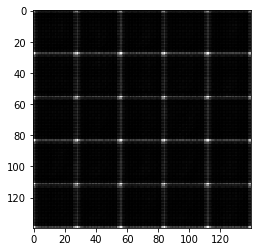

Epoch 1/2 Discriminator Loss0.6580 Generator Loss1.8493
Epoch 1/2 Discriminator Loss0.6713 Generator Loss2.1037
Epoch 1/2 Discriminator Loss0.8016 Generator Loss3.4469
Epoch 1/2 Discriminator Loss1.9200 Generator Loss0.4346
Epoch 1/2 Discriminator Loss1.5977 Generator Loss0.6209
Epoch 1/2 Discriminator Loss2.6299 Generator Loss0.1715
Epoch 1/2 Discriminator Loss2.5116 Generator Loss0.1470
Epoch 1/2 Discriminator Loss1.3252 Generator Loss0.9780
Epoch 1/2 Discriminator Loss1.8638 Generator Loss0.3124
Epoch 1/2 Discriminator Loss1.8151 Generator Loss0.7415


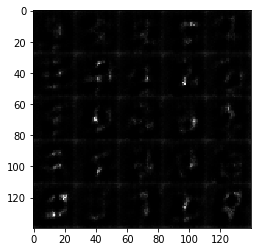

Epoch 1/2 Discriminator Loss2.0537 Generator Loss0.2317
Epoch 1/2 Discriminator Loss2.0752 Generator Loss1.3188
Epoch 1/2 Discriminator Loss1.6046 Generator Loss0.5854
Epoch 1/2 Discriminator Loss1.6510 Generator Loss1.0240
Epoch 1/2 Discriminator Loss1.8630 Generator Loss0.2773
Epoch 1/2 Discriminator Loss1.3140 Generator Loss0.7089
Epoch 1/2 Discriminator Loss1.7009 Generator Loss0.3520
Epoch 1/2 Discriminator Loss1.4816 Generator Loss1.1468
Epoch 1/2 Discriminator Loss1.3707 Generator Loss0.6295
Epoch 1/2 Discriminator Loss2.1214 Generator Loss0.1913


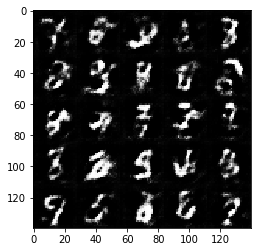

Epoch 1/2 Discriminator Loss1.2077 Generator Loss0.7172
Epoch 1/2 Discriminator Loss1.3759 Generator Loss0.6038
Epoch 1/2 Discriminator Loss1.2521 Generator Loss1.0518
Epoch 1/2 Discriminator Loss1.4105 Generator Loss0.4451
Epoch 1/2 Discriminator Loss1.2917 Generator Loss0.7729
Epoch 1/2 Discriminator Loss1.1739 Generator Loss1.0976
Epoch 1/2 Discriminator Loss1.4171 Generator Loss0.7007
Epoch 1/2 Discriminator Loss1.4255 Generator Loss0.4992
Epoch 1/2 Discriminator Loss1.1399 Generator Loss1.0683
Epoch 1/2 Discriminator Loss1.0301 Generator Loss1.1185


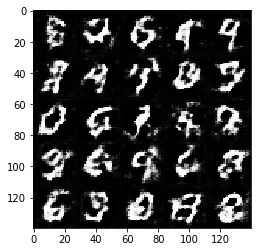

Epoch 1/2 Discriminator Loss1.2209 Generator Loss0.6522
Epoch 1/2 Discriminator Loss1.4195 Generator Loss0.4751
Epoch 1/2 Discriminator Loss1.4752 Generator Loss1.6220
Epoch 1/2 Discriminator Loss1.1845 Generator Loss0.9063
Epoch 1/2 Discriminator Loss1.3507 Generator Loss0.5732
Epoch 1/2 Discriminator Loss1.0937 Generator Loss0.9461
Epoch 1/2 Discriminator Loss1.0541 Generator Loss1.4655
Epoch 1/2 Discriminator Loss1.4479 Generator Loss0.4354
Epoch 1/2 Discriminator Loss1.3458 Generator Loss0.5189
Epoch 1/2 Discriminator Loss1.1858 Generator Loss1.1381


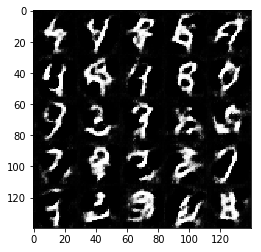

Epoch 1/2 Discriminator Loss1.1320 Generator Loss0.7711
Epoch 1/2 Discriminator Loss1.3007 Generator Loss0.6034
Epoch 1/2 Discriminator Loss1.3818 Generator Loss0.4643
Epoch 1/2 Discriminator Loss1.0801 Generator Loss0.9522
Epoch 1/2 Discriminator Loss1.3564 Generator Loss0.4534
Epoch 1/2 Discriminator Loss1.4224 Generator Loss2.4572
Epoch 1/2 Discriminator Loss1.2915 Generator Loss1.9560
Epoch 1/2 Discriminator Loss1.2771 Generator Loss0.7269
Epoch 1/2 Discriminator Loss1.3189 Generator Loss0.5379
Epoch 1/2 Discriminator Loss1.2039 Generator Loss0.9177


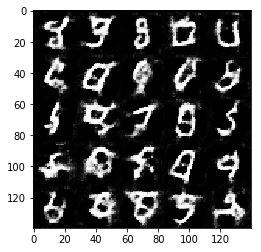

Epoch 1/2 Discriminator Loss1.1713 Generator Loss0.7508
Epoch 1/2 Discriminator Loss1.2789 Generator Loss0.6323
Epoch 1/2 Discriminator Loss1.5597 Generator Loss0.3798
Epoch 1/2 Discriminator Loss1.3192 Generator Loss0.9284
Epoch 1/2 Discriminator Loss1.3271 Generator Loss0.6136
Epoch 1/2 Discriminator Loss1.5118 Generator Loss0.4870
Epoch 1/2 Discriminator Loss1.5862 Generator Loss0.3614
Epoch 1/2 Discriminator Loss1.1647 Generator Loss1.5018
Epoch 1/2 Discriminator Loss1.2725 Generator Loss0.5426
Epoch 1/2 Discriminator Loss1.3195 Generator Loss1.0726


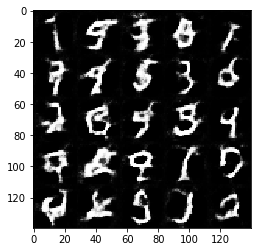

Epoch 1/2 Discriminator Loss1.1138 Generator Loss1.0044
Epoch 1/2 Discriminator Loss1.0522 Generator Loss1.5031
Epoch 1/2 Discriminator Loss1.6089 Generator Loss1.6147
Epoch 1/2 Discriminator Loss1.2833 Generator Loss0.6432
Epoch 1/2 Discriminator Loss1.2394 Generator Loss0.6220
Epoch 1/2 Discriminator Loss1.1322 Generator Loss1.0528
Epoch 1/2 Discriminator Loss1.4020 Generator Loss0.5152
Epoch 1/2 Discriminator Loss1.3309 Generator Loss1.3624
Epoch 1/2 Discriminator Loss1.5752 Generator Loss0.4730
Epoch 1/2 Discriminator Loss1.6202 Generator Loss0.3482


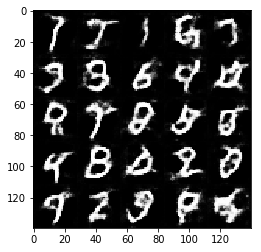

Epoch 1/2 Discriminator Loss1.2280 Generator Loss0.6397
Epoch 1/2 Discriminator Loss1.0733 Generator Loss1.2432
Epoch 1/2 Discriminator Loss1.0645 Generator Loss1.8622
Epoch 1/2 Discriminator Loss1.4951 Generator Loss1.1403
Epoch 1/2 Discriminator Loss1.1016 Generator Loss0.7301
Epoch 1/2 Discriminator Loss1.1941 Generator Loss0.6574
Epoch 1/2 Discriminator Loss1.0536 Generator Loss0.8766
Epoch 1/2 Discriminator Loss1.1825 Generator Loss1.9481
Epoch 1/2 Discriminator Loss1.5115 Generator Loss0.3753
Epoch 1/2 Discriminator Loss1.8248 Generator Loss0.2830


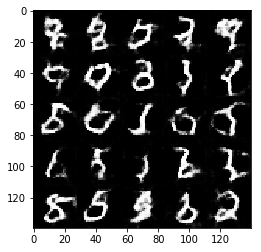

Epoch 1/2 Discriminator Loss1.0994 Generator Loss0.8340
Epoch 1/2 Discriminator Loss1.2986 Generator Loss0.5660
Epoch 1/2 Discriminator Loss1.2257 Generator Loss0.7904
Epoch 1/2 Discriminator Loss1.4320 Generator Loss1.9569
Epoch 1/2 Discriminator Loss1.1827 Generator Loss0.7025
Epoch 1/2 Discriminator Loss1.3767 Generator Loss0.5067
Epoch 1/2 Discriminator Loss1.0197 Generator Loss1.0537
Epoch 1/2 Discriminator Loss1.0402 Generator Loss1.0891
Epoch 1/2 Discriminator Loss1.3928 Generator Loss1.9862
Epoch 1/2 Discriminator Loss1.0931 Generator Loss1.0963


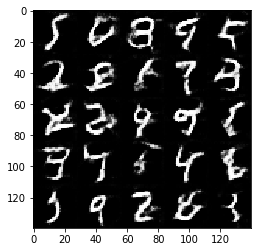

Epoch 1/2 Discriminator Loss1.0103 Generator Loss0.9896
Epoch 1/2 Discriminator Loss1.1455 Generator Loss0.8324
Epoch 1/2 Discriminator Loss1.2147 Generator Loss1.1878
Epoch 1/2 Discriminator Loss1.2122 Generator Loss0.7231
Epoch 1/2 Discriminator Loss0.8473 Generator Loss1.3050
Epoch 1/2 Discriminator Loss1.3164 Generator Loss1.6988
Epoch 1/2 Discriminator Loss1.2654 Generator Loss0.7420
Epoch 1/2 Discriminator Loss1.2805 Generator Loss0.6431
Epoch 1/2 Discriminator Loss1.8452 Generator Loss0.2857
Epoch 1/2 Discriminator Loss1.1037 Generator Loss1.1987


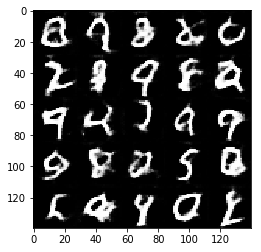

Epoch 1/2 Discriminator Loss1.1502 Generator Loss0.8397
Epoch 1/2 Discriminator Loss1.0417 Generator Loss0.8642
Epoch 1/2 Discriminator Loss1.2619 Generator Loss0.6328
Epoch 1/2 Discriminator Loss1.2605 Generator Loss0.7301
Epoch 1/2 Discriminator Loss1.2340 Generator Loss1.7961
Epoch 1/2 Discriminator Loss1.2415 Generator Loss0.8230
Epoch 1/2 Discriminator Loss1.2310 Generator Loss0.7731
Epoch 1/2 Discriminator Loss1.6190 Generator Loss0.3558
Epoch 1/2 Discriminator Loss1.5457 Generator Loss0.4691
Epoch 1/2 Discriminator Loss1.2167 Generator Loss0.7689


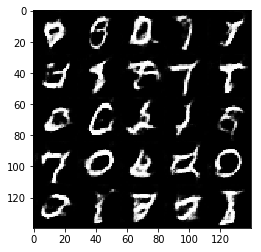

Epoch 1/2 Discriminator Loss1.3454 Generator Loss0.6336
Epoch 1/2 Discriminator Loss1.1180 Generator Loss1.4700
Epoch 1/2 Discriminator Loss0.9988 Generator Loss1.1567
Epoch 1/2 Discriminator Loss1.2458 Generator Loss1.6804
Epoch 1/2 Discriminator Loss1.3293 Generator Loss0.8958
Epoch 1/2 Discriminator Loss1.5459 Generator Loss0.4308
Epoch 1/2 Discriminator Loss1.9165 Generator Loss0.2800
Epoch 1/2 Discriminator Loss1.6051 Generator Loss1.9741
Epoch 1/2 Discriminator Loss1.1439 Generator Loss1.1244
Epoch 1/2 Discriminator Loss1.2385 Generator Loss0.7572


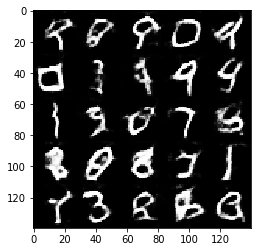

Epoch 1/2 Discriminator Loss1.2606 Generator Loss1.7193
Epoch 1/2 Discriminator Loss1.2330 Generator Loss0.6369
Epoch 1/2 Discriminator Loss1.2310 Generator Loss0.6409
Epoch 1/2 Discriminator Loss1.1741 Generator Loss1.1441
Epoch 1/2 Discriminator Loss1.2482 Generator Loss1.5739
Epoch 1/2 Discriminator Loss1.3210 Generator Loss0.5416
Epoch 1/2 Discriminator Loss1.2317 Generator Loss0.6697
Epoch 1/2 Discriminator Loss1.2303 Generator Loss0.6910
Epoch 1/2 Discriminator Loss0.9635 Generator Loss1.3786
Epoch 1/2 Discriminator Loss1.2208 Generator Loss0.7157


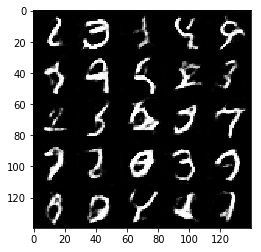

Epoch 1/2 Discriminator Loss1.3770 Generator Loss0.4446
Epoch 1/2 Discriminator Loss1.0092 Generator Loss0.7697
Epoch 1/2 Discriminator Loss1.2592 Generator Loss1.5515
Epoch 1/2 Discriminator Loss1.2351 Generator Loss2.0931
Epoch 1/2 Discriminator Loss1.1230 Generator Loss0.6808
Epoch 1/2 Discriminator Loss1.1217 Generator Loss1.4880
Epoch 1/2 Discriminator Loss1.2331 Generator Loss0.8353
Epoch 1/2 Discriminator Loss1.1758 Generator Loss0.8548
Epoch 1/2 Discriminator Loss1.1182 Generator Loss0.8957
Epoch 1/2 Discriminator Loss0.9106 Generator Loss1.0127


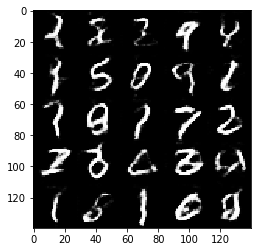

Epoch 1/2 Discriminator Loss1.9128 Generator Loss0.2973
Epoch 1/2 Discriminator Loss1.0826 Generator Loss0.8913
Epoch 1/2 Discriminator Loss1.2430 Generator Loss1.5146
Epoch 1/2 Discriminator Loss1.0303 Generator Loss0.8390
Epoch 1/2 Discriminator Loss1.0061 Generator Loss1.1226
Epoch 1/2 Discriminator Loss1.2669 Generator Loss0.6048
Epoch 1/2 Discriminator Loss1.0624 Generator Loss0.8929
Epoch 1/2 Discriminator Loss1.6196 Generator Loss0.3778
Epoch 1/2 Discriminator Loss1.2391 Generator Loss0.8064
Epoch 1/2 Discriminator Loss1.3062 Generator Loss0.6305


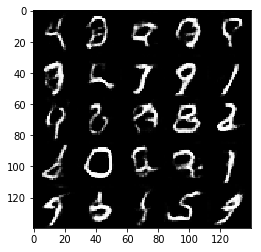

Epoch 1/2 Discriminator Loss1.1885 Generator Loss0.7267
Epoch 1/2 Discriminator Loss1.2489 Generator Loss0.7843
Epoch 1/2 Discriminator Loss1.1651 Generator Loss0.6831
Epoch 1/2 Discriminator Loss1.6512 Generator Loss0.3617
Epoch 1/2 Discriminator Loss0.9563 Generator Loss1.2812
Epoch 1/2 Discriminator Loss1.2361 Generator Loss0.6516
Epoch 1/2 Discriminator Loss1.0263 Generator Loss0.9729
Epoch 1/2 Discriminator Loss1.2514 Generator Loss0.9157
Epoch 1/2 Discriminator Loss1.3391 Generator Loss0.6225
Epoch 1/2 Discriminator Loss1.1674 Generator Loss0.8961


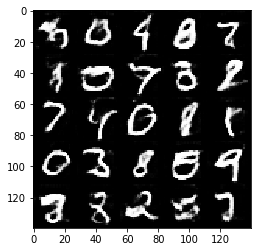

Epoch 1/2 Discriminator Loss1.4149 Generator Loss0.5286
Epoch 1/2 Discriminator Loss1.3000 Generator Loss0.8516
Epoch 1/2 Discriminator Loss1.2447 Generator Loss0.9732
Epoch 1/2 Discriminator Loss1.6494 Generator Loss0.3418
Epoch 1/2 Discriminator Loss1.1652 Generator Loss0.9833
Epoch 1/2 Discriminator Loss1.2420 Generator Loss0.6559
Epoch 1/2 Discriminator Loss1.1371 Generator Loss1.0320
Epoch 1/2 Discriminator Loss1.1839 Generator Loss0.7422
Epoch 1/2 Discriminator Loss1.1821 Generator Loss0.8556
Epoch 1/2 Discriminator Loss1.7783 Generator Loss0.2743


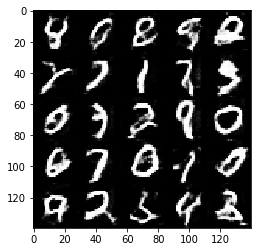

Epoch 1/2 Discriminator Loss1.1431 Generator Loss0.9678
Epoch 1/2 Discriminator Loss1.1636 Generator Loss1.5848
Epoch 1/2 Discriminator Loss1.5336 Generator Loss0.4603
Epoch 1/2 Discriminator Loss1.1766 Generator Loss0.9008
Epoch 1/2 Discriminator Loss0.9835 Generator Loss1.1920
Epoch 1/2 Discriminator Loss1.1894 Generator Loss1.5603
Epoch 1/2 Discriminator Loss1.0007 Generator Loss0.9364
Epoch 2/2 Discriminator Loss1.3343 Generator Loss0.5561
Epoch 2/2 Discriminator Loss1.3701 Generator Loss0.7573
Epoch 2/2 Discriminator Loss1.0760 Generator Loss0.8714


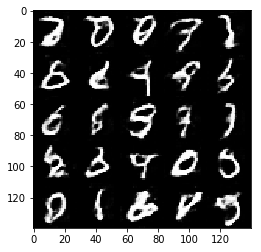

Epoch 2/2 Discriminator Loss1.1323 Generator Loss1.0262
Epoch 2/2 Discriminator Loss1.2742 Generator Loss1.8934
Epoch 2/2 Discriminator Loss1.1815 Generator Loss0.8070
Epoch 2/2 Discriminator Loss1.2196 Generator Loss0.6829
Epoch 2/2 Discriminator Loss1.3634 Generator Loss0.5896
Epoch 2/2 Discriminator Loss1.0885 Generator Loss1.0412
Epoch 2/2 Discriminator Loss1.3433 Generator Loss1.6277
Epoch 2/2 Discriminator Loss1.5514 Generator Loss0.4529
Epoch 2/2 Discriminator Loss1.0893 Generator Loss1.1291
Epoch 2/2 Discriminator Loss1.3876 Generator Loss0.5396


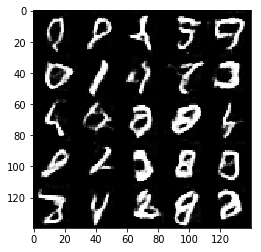

Epoch 2/2 Discriminator Loss1.2403 Generator Loss1.3394
Epoch 2/2 Discriminator Loss1.8184 Generator Loss0.3132
Epoch 2/2 Discriminator Loss1.2740 Generator Loss0.9950
Epoch 2/2 Discriminator Loss0.8956 Generator Loss1.1373
Epoch 2/2 Discriminator Loss1.0919 Generator Loss1.3988
Epoch 2/2 Discriminator Loss1.4322 Generator Loss0.4999
Epoch 2/2 Discriminator Loss1.1327 Generator Loss1.4346
Epoch 2/2 Discriminator Loss1.1272 Generator Loss0.9377
Epoch 2/2 Discriminator Loss1.0971 Generator Loss0.8294
Epoch 2/2 Discriminator Loss1.2689 Generator Loss0.6056


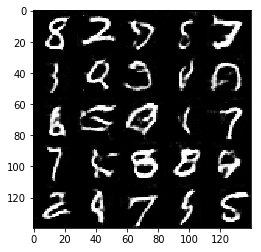

Epoch 2/2 Discriminator Loss1.3032 Generator Loss0.5812
Epoch 2/2 Discriminator Loss1.5199 Generator Loss0.4003
Epoch 2/2 Discriminator Loss1.2547 Generator Loss0.6457
Epoch 2/2 Discriminator Loss1.1854 Generator Loss0.6644
Epoch 2/2 Discriminator Loss1.2714 Generator Loss0.7840
Epoch 2/2 Discriminator Loss1.3821 Generator Loss0.6649
Epoch 2/2 Discriminator Loss1.1964 Generator Loss0.8896
Epoch 2/2 Discriminator Loss1.3359 Generator Loss0.4948
Epoch 2/2 Discriminator Loss1.0824 Generator Loss0.9903
Epoch 2/2 Discriminator Loss1.2876 Generator Loss1.3232


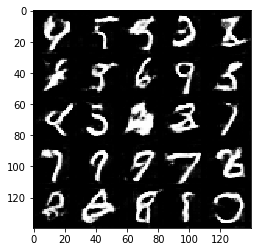

Epoch 2/2 Discriminator Loss1.1488 Generator Loss1.0177
Epoch 2/2 Discriminator Loss1.0762 Generator Loss0.9980
Epoch 2/2 Discriminator Loss1.0789 Generator Loss0.9371
Epoch 2/2 Discriminator Loss1.2162 Generator Loss0.8601
Epoch 2/2 Discriminator Loss1.5583 Generator Loss0.4317
Epoch 2/2 Discriminator Loss1.2415 Generator Loss0.8274
Epoch 2/2 Discriminator Loss1.1478 Generator Loss0.9970
Epoch 2/2 Discriminator Loss1.1612 Generator Loss1.7286
Epoch 2/2 Discriminator Loss1.2351 Generator Loss0.5890
Epoch 2/2 Discriminator Loss1.4175 Generator Loss0.8462


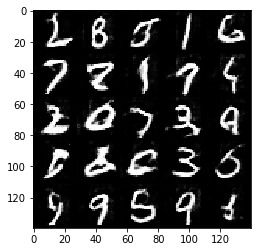

Epoch 2/2 Discriminator Loss0.9935 Generator Loss1.1732
Epoch 2/2 Discriminator Loss1.2945 Generator Loss1.2714
Epoch 2/2 Discriminator Loss1.4451 Generator Loss0.4888
Epoch 2/2 Discriminator Loss1.0701 Generator Loss1.1754
Epoch 2/2 Discriminator Loss1.2870 Generator Loss1.2717
Epoch 2/2 Discriminator Loss1.0535 Generator Loss1.1530
Epoch 2/2 Discriminator Loss1.2739 Generator Loss0.9184
Epoch 2/2 Discriminator Loss1.5198 Generator Loss0.4757
Epoch 2/2 Discriminator Loss1.2778 Generator Loss0.8611
Epoch 2/2 Discriminator Loss1.2969 Generator Loss0.6565


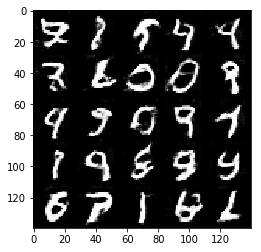

Epoch 2/2 Discriminator Loss1.1448 Generator Loss0.8861
Epoch 2/2 Discriminator Loss1.2604 Generator Loss0.4904
Epoch 2/2 Discriminator Loss1.3842 Generator Loss0.5531
Epoch 2/2 Discriminator Loss1.3455 Generator Loss0.6212
Epoch 2/2 Discriminator Loss1.3730 Generator Loss0.6179
Epoch 2/2 Discriminator Loss1.0873 Generator Loss0.9010
Epoch 2/2 Discriminator Loss1.2594 Generator Loss0.6183
Epoch 2/2 Discriminator Loss1.2840 Generator Loss0.8185
Epoch 2/2 Discriminator Loss1.6115 Generator Loss0.3592
Epoch 2/2 Discriminator Loss1.1859 Generator Loss0.8949


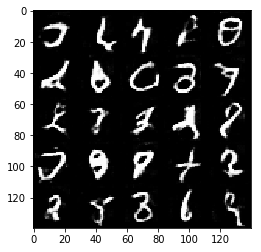

Epoch 2/2 Discriminator Loss1.2363 Generator Loss1.2138
Epoch 2/2 Discriminator Loss1.4349 Generator Loss0.5347
Epoch 2/2 Discriminator Loss1.1088 Generator Loss0.8723
Epoch 2/2 Discriminator Loss1.1805 Generator Loss0.6360
Epoch 2/2 Discriminator Loss1.3765 Generator Loss0.7139
Epoch 2/2 Discriminator Loss1.0373 Generator Loss0.8129
Epoch 2/2 Discriminator Loss0.9824 Generator Loss1.1585
Epoch 2/2 Discriminator Loss1.2566 Generator Loss1.2009
Epoch 2/2 Discriminator Loss1.2668 Generator Loss0.6051
Epoch 2/2 Discriminator Loss1.3763 Generator Loss0.8517


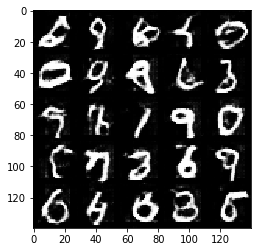

Epoch 2/2 Discriminator Loss1.0639 Generator Loss0.9719
Epoch 2/2 Discriminator Loss1.1733 Generator Loss1.2323
Epoch 2/2 Discriminator Loss1.3978 Generator Loss0.4484
Epoch 2/2 Discriminator Loss1.2257 Generator Loss1.3795
Epoch 2/2 Discriminator Loss1.3663 Generator Loss0.9571
Epoch 2/2 Discriminator Loss1.4306 Generator Loss0.4517
Epoch 2/2 Discriminator Loss1.2953 Generator Loss0.7812
Epoch 2/2 Discriminator Loss1.2636 Generator Loss0.7531
Epoch 2/2 Discriminator Loss1.4631 Generator Loss0.4894
Epoch 2/2 Discriminator Loss1.3711 Generator Loss0.5516


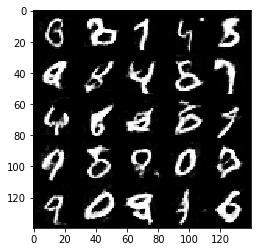

Epoch 2/2 Discriminator Loss1.0828 Generator Loss1.4649
Epoch 2/2 Discriminator Loss1.0506 Generator Loss0.8241
Epoch 2/2 Discriminator Loss1.0210 Generator Loss0.9649
Epoch 2/2 Discriminator Loss1.1911 Generator Loss1.0712
Epoch 2/2 Discriminator Loss1.3210 Generator Loss0.6250
Epoch 2/2 Discriminator Loss1.2150 Generator Loss0.6529
Epoch 2/2 Discriminator Loss1.0750 Generator Loss1.3800
Epoch 2/2 Discriminator Loss1.3859 Generator Loss0.4215
Epoch 2/2 Discriminator Loss1.3450 Generator Loss0.5892
Epoch 2/2 Discriminator Loss1.2242 Generator Loss0.8329


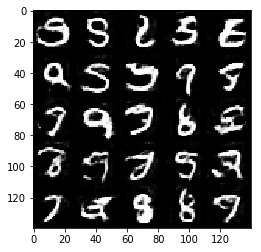

Epoch 2/2 Discriminator Loss1.1193 Generator Loss1.0181
Epoch 2/2 Discriminator Loss0.9798 Generator Loss0.9646
Epoch 2/2 Discriminator Loss1.2541 Generator Loss0.6269
Epoch 2/2 Discriminator Loss0.9493 Generator Loss1.1132
Epoch 2/2 Discriminator Loss1.2762 Generator Loss1.2039
Epoch 2/2 Discriminator Loss1.2840 Generator Loss1.4868
Epoch 2/2 Discriminator Loss1.3183 Generator Loss0.5973
Epoch 2/2 Discriminator Loss1.2127 Generator Loss0.7084
Epoch 2/2 Discriminator Loss1.0355 Generator Loss1.1665
Epoch 2/2 Discriminator Loss1.1879 Generator Loss1.0941


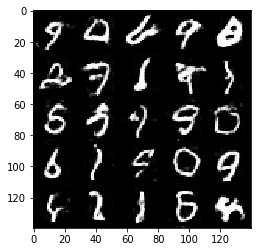

Epoch 2/2 Discriminator Loss1.1533 Generator Loss0.8146
Epoch 2/2 Discriminator Loss1.1781 Generator Loss0.9907
Epoch 2/2 Discriminator Loss1.2517 Generator Loss0.7168
Epoch 2/2 Discriminator Loss1.3018 Generator Loss0.7421
Epoch 2/2 Discriminator Loss1.3807 Generator Loss1.4077
Epoch 2/2 Discriminator Loss1.4946 Generator Loss0.3893
Epoch 2/2 Discriminator Loss1.2103 Generator Loss0.6534
Epoch 2/2 Discriminator Loss1.1382 Generator Loss1.1678
Epoch 2/2 Discriminator Loss1.1280 Generator Loss0.9843
Epoch 2/2 Discriminator Loss1.3674 Generator Loss0.8427


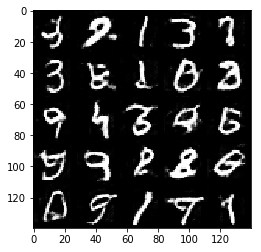

Epoch 2/2 Discriminator Loss1.1733 Generator Loss0.8005
Epoch 2/2 Discriminator Loss1.0103 Generator Loss1.3013
Epoch 2/2 Discriminator Loss1.2541 Generator Loss0.8906
Epoch 2/2 Discriminator Loss1.2122 Generator Loss0.7453
Epoch 2/2 Discriminator Loss1.2484 Generator Loss0.6566
Epoch 2/2 Discriminator Loss1.3029 Generator Loss0.5591
Epoch 2/2 Discriminator Loss1.2320 Generator Loss0.8376
Epoch 2/2 Discriminator Loss1.1610 Generator Loss1.3086
Epoch 2/2 Discriminator Loss1.1807 Generator Loss0.7337
Epoch 2/2 Discriminator Loss1.4107 Generator Loss0.4625


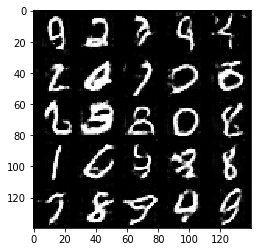

Epoch 2/2 Discriminator Loss1.1934 Generator Loss0.7519
Epoch 2/2 Discriminator Loss1.0736 Generator Loss0.9678
Epoch 2/2 Discriminator Loss1.3476 Generator Loss0.5645
Epoch 2/2 Discriminator Loss1.3303 Generator Loss0.5443
Epoch 2/2 Discriminator Loss1.0463 Generator Loss1.0879
Epoch 2/2 Discriminator Loss1.3670 Generator Loss0.4902
Epoch 2/2 Discriminator Loss1.0599 Generator Loss0.9535
Epoch 2/2 Discriminator Loss1.3336 Generator Loss0.5180
Epoch 2/2 Discriminator Loss1.1153 Generator Loss1.0905
Epoch 2/2 Discriminator Loss1.2238 Generator Loss0.7127


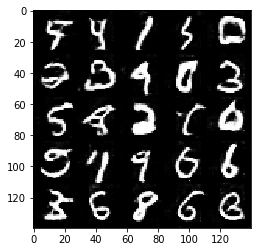

Epoch 2/2 Discriminator Loss1.2311 Generator Loss0.9314
Epoch 2/2 Discriminator Loss1.5046 Generator Loss0.5369
Epoch 2/2 Discriminator Loss1.2555 Generator Loss0.9544
Epoch 2/2 Discriminator Loss1.2809 Generator Loss0.8116
Epoch 2/2 Discriminator Loss1.4581 Generator Loss0.4825
Epoch 2/2 Discriminator Loss1.3287 Generator Loss0.7400
Epoch 2/2 Discriminator Loss1.4331 Generator Loss0.4862
Epoch 2/2 Discriminator Loss1.2119 Generator Loss0.5957
Epoch 2/2 Discriminator Loss1.1303 Generator Loss1.1778
Epoch 2/2 Discriminator Loss1.3177 Generator Loss1.3399


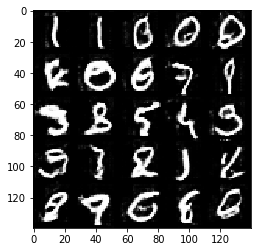

Epoch 2/2 Discriminator Loss1.1839 Generator Loss0.7085
Epoch 2/2 Discriminator Loss1.3673 Generator Loss0.5081
Epoch 2/2 Discriminator Loss1.0103 Generator Loss1.0044
Epoch 2/2 Discriminator Loss1.2391 Generator Loss0.6727
Epoch 2/2 Discriminator Loss1.0254 Generator Loss1.2898
Epoch 2/2 Discriminator Loss1.2209 Generator Loss0.8173
Epoch 2/2 Discriminator Loss1.3265 Generator Loss0.5060
Epoch 2/2 Discriminator Loss1.3681 Generator Loss0.9162
Epoch 2/2 Discriminator Loss1.2513 Generator Loss1.0091
Epoch 2/2 Discriminator Loss1.0545 Generator Loss1.0767


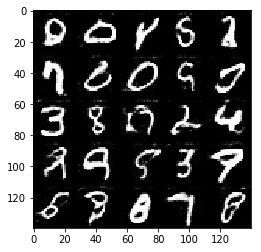

Epoch 2/2 Discriminator Loss1.2334 Generator Loss0.6782
Epoch 2/2 Discriminator Loss1.3402 Generator Loss0.5189
Epoch 2/2 Discriminator Loss1.3776 Generator Loss0.6173
Epoch 2/2 Discriminator Loss1.2801 Generator Loss1.4718
Epoch 2/2 Discriminator Loss1.0874 Generator Loss0.7193
Epoch 2/2 Discriminator Loss1.1352 Generator Loss0.7497
Epoch 2/2 Discriminator Loss1.5281 Generator Loss0.4507
Epoch 2/2 Discriminator Loss1.1947 Generator Loss0.7803
Epoch 2/2 Discriminator Loss1.0911 Generator Loss0.9654
Epoch 2/2 Discriminator Loss1.1245 Generator Loss0.7747


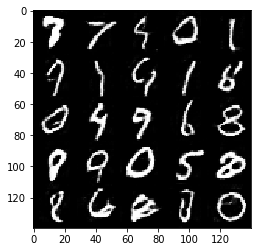

Epoch 2/2 Discriminator Loss1.2179 Generator Loss0.7892
Epoch 2/2 Discriminator Loss1.2851 Generator Loss0.7925
Epoch 2/2 Discriminator Loss1.4003 Generator Loss1.3791
Epoch 2/2 Discriminator Loss1.2184 Generator Loss0.9840
Epoch 2/2 Discriminator Loss1.0672 Generator Loss1.2375
Epoch 2/2 Discriminator Loss1.1905 Generator Loss0.6865
Epoch 2/2 Discriminator Loss1.1034 Generator Loss1.1568
Epoch 2/2 Discriminator Loss1.1303 Generator Loss0.6814
Epoch 2/2 Discriminator Loss1.4815 Generator Loss0.4039
Epoch 2/2 Discriminator Loss1.1959 Generator Loss1.0889


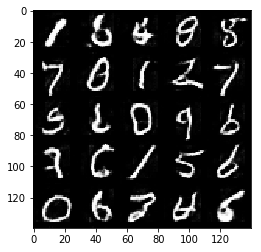

Epoch 2/2 Discriminator Loss1.2071 Generator Loss0.6620
Epoch 2/2 Discriminator Loss1.5810 Generator Loss0.3756
Epoch 2/2 Discriminator Loss1.1651 Generator Loss0.8600
Epoch 2/2 Discriminator Loss1.1630 Generator Loss0.7868
Epoch 2/2 Discriminator Loss1.2162 Generator Loss0.8211
Epoch 2/2 Discriminator Loss1.1750 Generator Loss0.8866
Epoch 2/2 Discriminator Loss1.0768 Generator Loss0.8858
Epoch 2/2 Discriminator Loss1.0467 Generator Loss0.9872
Epoch 2/2 Discriminator Loss1.1313 Generator Loss0.7779
Epoch 2/2 Discriminator Loss1.2379 Generator Loss0.6513


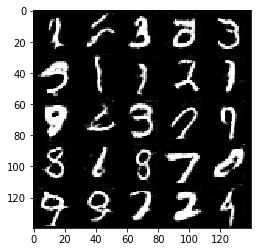

Epoch 2/2 Discriminator Loss1.2364 Generator Loss0.9499
Epoch 2/2 Discriminator Loss1.1065 Generator Loss0.8449
Epoch 2/2 Discriminator Loss1.4127 Generator Loss1.1852
Epoch 2/2 Discriminator Loss1.1846 Generator Loss0.8063
Epoch 2/2 Discriminator Loss1.1820 Generator Loss0.7813


In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Discriminator Loss-0.2699 Generator Loss0.4751
Epoch 1/1 Discriminator Loss1.1677 Generator Loss0.1861
Epoch 1/1 Discriminator Loss0.6749 Generator Loss1.6117
Epoch 1/1 Discriminator Loss2.6632 Generator Loss0.3203
Epoch 1/1 Discriminator Loss1.0685 Generator Loss9.8363
Epoch 1/1 Discriminator Loss1.9377 Generator Loss1.7079
Epoch 1/1 Discriminator Loss1.3152 Generator Loss1.1455
Epoch 1/1 Discriminator Loss-1.5550 Generator Loss3.0423
Epoch 1/1 Discriminator Loss1.8155 Generator Loss0.5708
Epoch 1/1 Discriminator Loss1.4212 Generator Loss0.5620


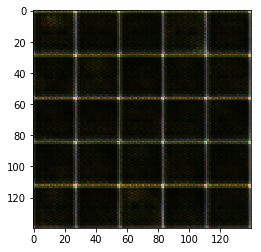

Epoch 1/1 Discriminator Loss2.8638 Generator Loss0.1894
Epoch 1/1 Discriminator Loss0.5690 Generator Loss1.9776
Epoch 1/1 Discriminator Loss3.4096 Generator Loss0.1034
Epoch 1/1 Discriminator Loss0.8963 Generator Loss0.9376
Epoch 1/1 Discriminator Loss0.8439 Generator Loss1.6266
Epoch 1/1 Discriminator Loss1.1778 Generator Loss1.5236
Epoch 1/1 Discriminator Loss2.3293 Generator Loss0.1187
Epoch 1/1 Discriminator Loss0.9854 Generator Loss1.9221
Epoch 1/1 Discriminator Loss1.5536 Generator Loss3.2591
Epoch 1/1 Discriminator Loss1.3909 Generator Loss0.2024


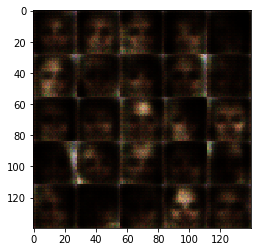

Epoch 1/1 Discriminator Loss2.1087 Generator Loss0.1141
Epoch 1/1 Discriminator Loss0.4083 Generator Loss0.5732
Epoch 1/1 Discriminator Loss0.7142 Generator Loss0.6966
Epoch 1/1 Discriminator Loss-0.2092 Generator Loss2.6290
Epoch 1/1 Discriminator Loss-0.4742 Generator Loss1.4721
Epoch 1/1 Discriminator Loss-0.6557 Generator Loss1.2200
Epoch 1/1 Discriminator Loss0.6628 Generator Loss0.4239
Epoch 1/1 Discriminator Loss-0.7021 Generator Loss4.1884
Epoch 1/1 Discriminator Loss-0.6769 Generator Loss2.2930
Epoch 1/1 Discriminator Loss-0.7497 Generator Loss2.0064


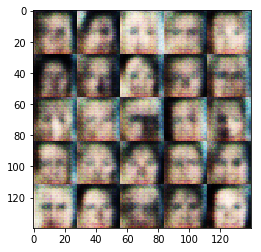

Epoch 1/1 Discriminator Loss-0.8249 Generator Loss2.0318
Epoch 1/1 Discriminator Loss-0.0444 Generator Loss0.9106
Epoch 1/1 Discriminator Loss-0.4337 Generator Loss2.5404
Epoch 1/1 Discriminator Loss-0.3759 Generator Loss2.2110
Epoch 1/1 Discriminator Loss-0.3499 Generator Loss1.4430
Epoch 1/1 Discriminator Loss0.4757 Generator Loss0.7174
Epoch 1/1 Discriminator Loss-0.8826 Generator Loss4.5645
Epoch 1/1 Discriminator Loss0.9018 Generator Loss0.6981
Epoch 1/1 Discriminator Loss-0.1254 Generator Loss2.6251
Epoch 1/1 Discriminator Loss-0.0702 Generator Loss1.1823


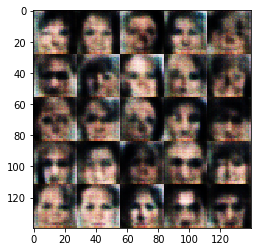

Epoch 1/1 Discriminator Loss-0.2064 Generator Loss2.3402
Epoch 1/1 Discriminator Loss-0.6329 Generator Loss1.4344
Epoch 1/1 Discriminator Loss0.4064 Generator Loss2.1689
Epoch 1/1 Discriminator Loss-0.3494 Generator Loss1.0672
Epoch 1/1 Discriminator Loss-0.6377 Generator Loss2.3913
Epoch 1/1 Discriminator Loss-1.2387 Generator Loss3.2677
Epoch 1/1 Discriminator Loss0.5346 Generator Loss14.0966
Epoch 1/1 Discriminator Loss0.3109 Generator Loss4.1971
Epoch 1/1 Discriminator Loss-0.5284 Generator Loss4.7887
Epoch 1/1 Discriminator Loss-0.9931 Generator Loss4.1700


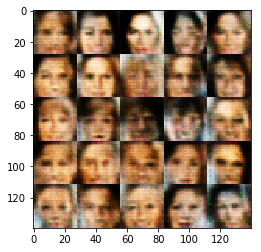

Epoch 1/1 Discriminator Loss0.5421 Generator Loss0.3839
Epoch 1/1 Discriminator Loss-0.2974 Generator Loss8.2998
Epoch 1/1 Discriminator Loss-0.8571 Generator Loss4.7054
Epoch 1/1 Discriminator Loss0.1084 Generator Loss3.6743
Epoch 1/1 Discriminator Loss-0.6938 Generator Loss1.7290
Epoch 1/1 Discriminator Loss1.5858 Generator Loss0.1530
Epoch 1/1 Discriminator Loss0.6436 Generator Loss0.2688
Epoch 1/1 Discriminator Loss-0.5778 Generator Loss6.1624
Epoch 1/1 Discriminator Loss-1.1666 Generator Loss2.4094
Epoch 1/1 Discriminator Loss-0.6194 Generator Loss1.2342


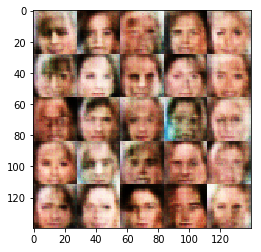

Epoch 1/1 Discriminator Loss-0.9167 Generator Loss1.4118
Epoch 1/1 Discriminator Loss-0.6848 Generator Loss1.4509
Epoch 1/1 Discriminator Loss0.6812 Generator Loss0.3736
Epoch 1/1 Discriminator Loss-1.0728 Generator Loss1.5119
Epoch 1/1 Discriminator Loss-1.3139 Generator Loss2.7994
Epoch 1/1 Discriminator Loss2.9424 Generator Loss0.4737
Epoch 1/1 Discriminator Loss-0.6956 Generator Loss2.1462
Epoch 1/1 Discriminator Loss0.9742 Generator Loss13.0222
Epoch 1/1 Discriminator Loss3.0823 Generator Loss0.0306
Epoch 1/1 Discriminator Loss4.7225 Generator Loss0.0038


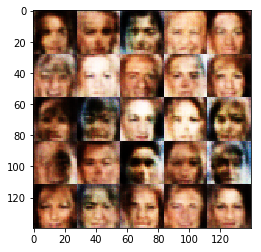

Epoch 1/1 Discriminator Loss-0.9526 Generator Loss3.0879
Epoch 1/1 Discriminator Loss2.8313 Generator Loss0.0713
Epoch 1/1 Discriminator Loss-0.1886 Generator Loss3.2647
Epoch 1/1 Discriminator Loss-0.3396 Generator Loss10.3734
Epoch 1/1 Discriminator Loss1.4587 Generator Loss1.4165
Epoch 1/1 Discriminator Loss-0.2103 Generator Loss1.8930
Epoch 1/1 Discriminator Loss0.2850 Generator Loss1.4484
Epoch 1/1 Discriminator Loss1.3360 Generator Loss0.4180
Epoch 1/1 Discriminator Loss2.4908 Generator Loss0.0451
Epoch 1/1 Discriminator Loss0.2734 Generator Loss5.8791


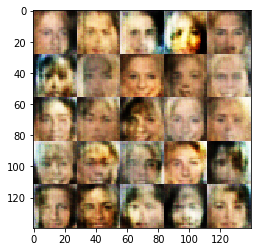

Epoch 1/1 Discriminator Loss0.3772 Generator Loss4.0544
Epoch 1/1 Discriminator Loss-0.3738 Generator Loss2.6881
Epoch 1/1 Discriminator Loss-0.0391 Generator Loss4.9773
Epoch 1/1 Discriminator Loss1.8963 Generator Loss0.1627
Epoch 1/1 Discriminator Loss1.3962 Generator Loss0.2291
Epoch 1/1 Discriminator Loss0.5147 Generator Loss1.1687
Epoch 1/1 Discriminator Loss0.9897 Generator Loss1.0883
Epoch 1/1 Discriminator Loss2.0492 Generator Loss0.1075
Epoch 1/1 Discriminator Loss0.8806 Generator Loss4.3950
Epoch 1/1 Discriminator Loss-0.5150 Generator Loss2.3666


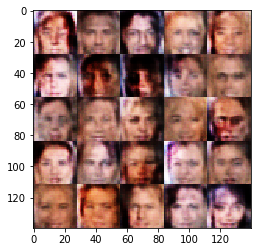

Epoch 1/1 Discriminator Loss0.1034 Generator Loss0.8464
Epoch 1/1 Discriminator Loss0.0211 Generator Loss4.8183
Epoch 1/1 Discriminator Loss1.2133 Generator Loss0.7324
Epoch 1/1 Discriminator Loss0.3602 Generator Loss3.0229
Epoch 1/1 Discriminator Loss2.0944 Generator Loss0.0958
Epoch 1/1 Discriminator Loss-0.4177 Generator Loss1.8766
Epoch 1/1 Discriminator Loss-0.2124 Generator Loss8.8827
Epoch 1/1 Discriminator Loss0.6142 Generator Loss0.6579
Epoch 1/1 Discriminator Loss1.0506 Generator Loss0.2811
Epoch 1/1 Discriminator Loss0.0574 Generator Loss1.0451


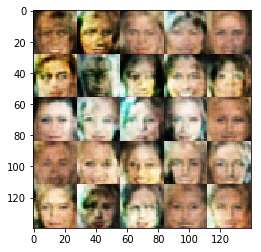

Epoch 1/1 Discriminator Loss0.5649 Generator Loss2.7416
Epoch 1/1 Discriminator Loss0.9444 Generator Loss0.2383
Epoch 1/1 Discriminator Loss-0.1308 Generator Loss3.4067
Epoch 1/1 Discriminator Loss0.2451 Generator Loss7.0699
Epoch 1/1 Discriminator Loss-0.4474 Generator Loss1.2513
Epoch 1/1 Discriminator Loss1.0341 Generator Loss0.5334
Epoch 1/1 Discriminator Loss2.1373 Generator Loss0.1311
Epoch 1/1 Discriminator Loss0.5995 Generator Loss0.5658
Epoch 1/1 Discriminator Loss1.9704 Generator Loss0.0899
Epoch 1/1 Discriminator Loss1.3526 Generator Loss2.3078


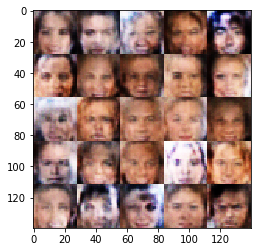

Epoch 1/1 Discriminator Loss0.7316 Generator Loss0.6866
Epoch 1/1 Discriminator Loss1.5619 Generator Loss0.2177
Epoch 1/1 Discriminator Loss0.6080 Generator Loss1.4159
Epoch 1/1 Discriminator Loss-0.3972 Generator Loss2.5964
Epoch 1/1 Discriminator Loss-0.2509 Generator Loss3.5879
Epoch 1/1 Discriminator Loss0.3801 Generator Loss1.2617
Epoch 1/1 Discriminator Loss1.9089 Generator Loss0.0985
Epoch 1/1 Discriminator Loss-0.5258 Generator Loss5.4950
Epoch 1/1 Discriminator Loss0.5914 Generator Loss1.3958
Epoch 1/1 Discriminator Loss4.0952 Generator Loss0.0067


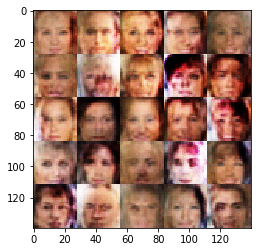

Epoch 1/1 Discriminator Loss-0.6971 Generator Loss4.4204
Epoch 1/1 Discriminator Loss1.6980 Generator Loss0.2231
Epoch 1/1 Discriminator Loss-0.2245 Generator Loss5.5166
Epoch 1/1 Discriminator Loss-0.6700 Generator Loss3.4340
Epoch 1/1 Discriminator Loss1.2276 Generator Loss0.1828
Epoch 1/1 Discriminator Loss-0.0950 Generator Loss0.7054
Epoch 1/1 Discriminator Loss-0.3246 Generator Loss2.1107
Epoch 1/1 Discriminator Loss-0.8116 Generator Loss3.1416
Epoch 1/1 Discriminator Loss-0.4306 Generator Loss1.7377
Epoch 1/1 Discriminator Loss0.2827 Generator Loss0.8707


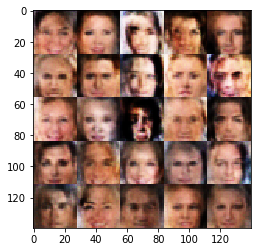

Epoch 1/1 Discriminator Loss0.7289 Generator Loss5.0516
Epoch 1/1 Discriminator Loss0.0307 Generator Loss4.5043
Epoch 1/1 Discriminator Loss-0.3131 Generator Loss2.1966
Epoch 1/1 Discriminator Loss0.0821 Generator Loss0.9767
Epoch 1/1 Discriminator Loss0.3049 Generator Loss4.4121
Epoch 1/1 Discriminator Loss0.7901 Generator Loss3.5123
Epoch 1/1 Discriminator Loss0.0691 Generator Loss2.6825
Epoch 1/1 Discriminator Loss-0.9368 Generator Loss4.9509
Epoch 1/1 Discriminator Loss-0.2699 Generator Loss4.4395
Epoch 1/1 Discriminator Loss0.6947 Generator Loss9.1758


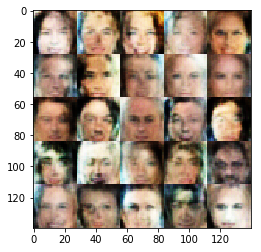

Epoch 1/1 Discriminator Loss0.0845 Generator Loss0.8768
Epoch 1/1 Discriminator Loss-0.7731 Generator Loss6.1840
Epoch 1/1 Discriminator Loss0.2799 Generator Loss0.8799
Epoch 1/1 Discriminator Loss0.1036 Generator Loss1.2846
Epoch 1/1 Discriminator Loss0.4508 Generator Loss1.5590
Epoch 1/1 Discriminator Loss-1.0168 Generator Loss8.7827
Epoch 1/1 Discriminator Loss1.0058 Generator Loss0.7097
Epoch 1/1 Discriminator Loss1.9714 Generator Loss0.0623
Epoch 1/1 Discriminator Loss1.0016 Generator Loss4.5058
Epoch 1/1 Discriminator Loss-0.5943 Generator Loss4.1366


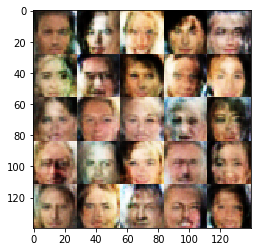

Epoch 1/1 Discriminator Loss3.5841 Generator Loss0.0269
Epoch 1/1 Discriminator Loss0.1078 Generator Loss2.8148
Epoch 1/1 Discriminator Loss0.6521 Generator Loss4.0481
Epoch 1/1 Discriminator Loss3.9880 Generator Loss0.0089
Epoch 1/1 Discriminator Loss-0.3477 Generator Loss2.5006
Epoch 1/1 Discriminator Loss1.5566 Generator Loss0.1582
Epoch 1/1 Discriminator Loss1.4914 Generator Loss0.1811
Epoch 1/1 Discriminator Loss1.5699 Generator Loss0.1781
Epoch 1/1 Discriminator Loss0.3921 Generator Loss0.7579
Epoch 1/1 Discriminator Loss1.0176 Generator Loss3.8590


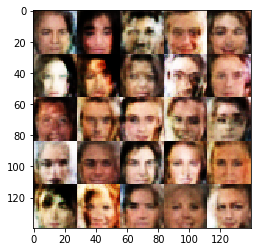

Epoch 1/1 Discriminator Loss0.5178 Generator Loss0.4434
Epoch 1/1 Discriminator Loss2.2923 Generator Loss0.1741
Epoch 1/1 Discriminator Loss0.1494 Generator Loss0.6623
Epoch 1/1 Discriminator Loss0.1927 Generator Loss0.5551
Epoch 1/1 Discriminator Loss2.8397 Generator Loss2.1795
Epoch 1/1 Discriminator Loss-0.5391 Generator Loss3.2121
Epoch 1/1 Discriminator Loss0.4853 Generator Loss1.4863
Epoch 1/1 Discriminator Loss-0.5157 Generator Loss6.2723
Epoch 1/1 Discriminator Loss-0.2179 Generator Loss4.1876
Epoch 1/1 Discriminator Loss-0.3056 Generator Loss1.8357


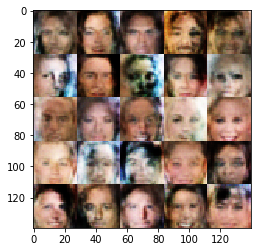

Epoch 1/1 Discriminator Loss2.6222 Generator Loss3.3995
Epoch 1/1 Discriminator Loss-0.3138 Generator Loss1.6626
Epoch 1/1 Discriminator Loss1.4988 Generator Loss0.1838
Epoch 1/1 Discriminator Loss0.1389 Generator Loss0.9666
Epoch 1/1 Discriminator Loss-0.0300 Generator Loss1.3347
Epoch 1/1 Discriminator Loss2.0031 Generator Loss1.8942
Epoch 1/1 Discriminator Loss-0.0647 Generator Loss0.9033
Epoch 1/1 Discriminator Loss3.1198 Generator Loss0.0143
Epoch 1/1 Discriminator Loss-1.0845 Generator Loss4.1172
Epoch 1/1 Discriminator Loss-0.5138 Generator Loss2.8131


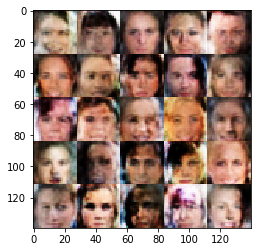

Epoch 1/1 Discriminator Loss-0.1692 Generator Loss0.9660
Epoch 1/1 Discriminator Loss0.7233 Generator Loss0.2891
Epoch 1/1 Discriminator Loss1.4302 Generator Loss2.7856
Epoch 1/1 Discriminator Loss1.5735 Generator Loss0.1229
Epoch 1/1 Discriminator Loss3.2574 Generator Loss0.0602
Epoch 1/1 Discriminator Loss-0.6351 Generator Loss4.2215
Epoch 1/1 Discriminator Loss1.2747 Generator Loss0.1296
Epoch 1/1 Discriminator Loss-0.4508 Generator Loss4.9104
Epoch 1/1 Discriminator Loss5.1873 Generator Loss0.0026
Epoch 1/1 Discriminator Loss0.6473 Generator Loss0.3287


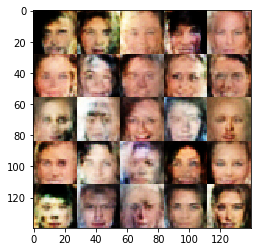

Epoch 1/1 Discriminator Loss1.4071 Generator Loss1.6109
Epoch 1/1 Discriminator Loss-0.1608 Generator Loss1.1399
Epoch 1/1 Discriminator Loss0.9447 Generator Loss0.4074
Epoch 1/1 Discriminator Loss2.6832 Generator Loss0.0822
Epoch 1/1 Discriminator Loss0.4711 Generator Loss4.2254
Epoch 1/1 Discriminator Loss-0.7507 Generator Loss6.5485
Epoch 1/1 Discriminator Loss1.0083 Generator Loss4.0741
Epoch 1/1 Discriminator Loss-0.5222 Generator Loss2.7043
Epoch 1/1 Discriminator Loss0.1596 Generator Loss12.2688
Epoch 1/1 Discriminator Loss1.2426 Generator Loss6.3717


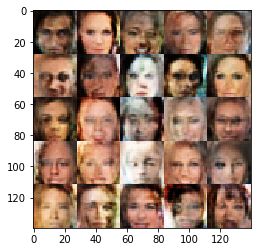

Epoch 1/1 Discriminator Loss-0.4522 Generator Loss1.5725
Epoch 1/1 Discriminator Loss-0.1426 Generator Loss1.7496
Epoch 1/1 Discriminator Loss-0.2194 Generator Loss3.2946
Epoch 1/1 Discriminator Loss-0.7434 Generator Loss4.4867
Epoch 1/1 Discriminator Loss2.4547 Generator Loss0.2066
Epoch 1/1 Discriminator Loss-0.1533 Generator Loss1.5126
Epoch 1/1 Discriminator Loss0.5952 Generator Loss0.6280
Epoch 1/1 Discriminator Loss1.5162 Generator Loss0.1585
Epoch 1/1 Discriminator Loss0.5680 Generator Loss1.1256
Epoch 1/1 Discriminator Loss-0.7897 Generator Loss2.3077


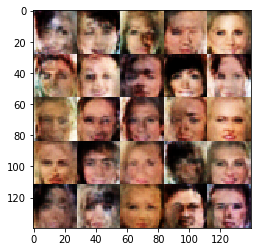

Epoch 1/1 Discriminator Loss1.1017 Generator Loss3.0404
Epoch 1/1 Discriminator Loss-0.5293 Generator Loss2.4228
Epoch 1/1 Discriminator Loss0.3670 Generator Loss1.2829
Epoch 1/1 Discriminator Loss0.2031 Generator Loss0.3657
Epoch 1/1 Discriminator Loss-0.1645 Generator Loss1.4340
Epoch 1/1 Discriminator Loss1.4247 Generator Loss0.2861
Epoch 1/1 Discriminator Loss-0.5361 Generator Loss4.4697
Epoch 1/1 Discriminator Loss-0.1694 Generator Loss1.1177
Epoch 1/1 Discriminator Loss0.6519 Generator Loss3.9669
Epoch 1/1 Discriminator Loss0.3869 Generator Loss1.0995


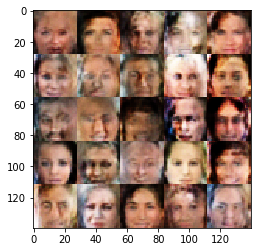

Epoch 1/1 Discriminator Loss1.6222 Generator Loss0.7350
Epoch 1/1 Discriminator Loss2.4287 Generator Loss0.0643
Epoch 1/1 Discriminator Loss3.7835 Generator Loss0.0254
Epoch 1/1 Discriminator Loss-0.3417 Generator Loss1.2797
Epoch 1/1 Discriminator Loss-0.0802 Generator Loss1.4237
Epoch 1/1 Discriminator Loss-0.1263 Generator Loss1.0567
Epoch 1/1 Discriminator Loss0.0936 Generator Loss0.6945
Epoch 1/1 Discriminator Loss1.3798 Generator Loss0.3253
Epoch 1/1 Discriminator Loss0.1658 Generator Loss2.5920
Epoch 1/1 Discriminator Loss-0.1534 Generator Loss2.2145


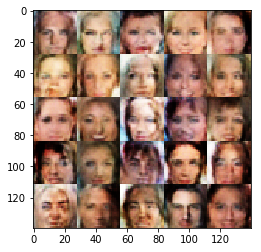

Epoch 1/1 Discriminator Loss2.2744 Generator Loss3.8136
Epoch 1/1 Discriminator Loss0.6147 Generator Loss0.6588
Epoch 1/1 Discriminator Loss0.4520 Generator Loss0.4658
Epoch 1/1 Discriminator Loss0.1415 Generator Loss3.3882
Epoch 1/1 Discriminator Loss1.7460 Generator Loss0.0821
Epoch 1/1 Discriminator Loss1.3642 Generator Loss0.5580
Epoch 1/1 Discriminator Loss-0.2704 Generator Loss1.4678
Epoch 1/1 Discriminator Loss0.8167 Generator Loss1.3707
Epoch 1/1 Discriminator Loss-0.1922 Generator Loss3.9752
Epoch 1/1 Discriminator Loss0.8546 Generator Loss0.6175


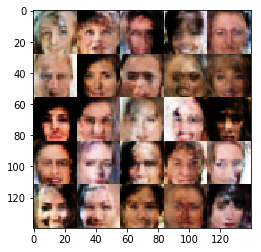

Epoch 1/1 Discriminator Loss-0.4855 Generator Loss1.8009
Epoch 1/1 Discriminator Loss0.5547 Generator Loss1.6042
Epoch 1/1 Discriminator Loss-0.0242 Generator Loss5.1423
Epoch 1/1 Discriminator Loss0.2735 Generator Loss1.3856
Epoch 1/1 Discriminator Loss0.3200 Generator Loss1.8368
Epoch 1/1 Discriminator Loss2.9533 Generator Loss0.0506
Epoch 1/1 Discriminator Loss0.7783 Generator Loss0.6251
Epoch 1/1 Discriminator Loss0.6672 Generator Loss0.8462
Epoch 1/1 Discriminator Loss-0.0345 Generator Loss2.1289
Epoch 1/1 Discriminator Loss-0.3252 Generator Loss2.3718


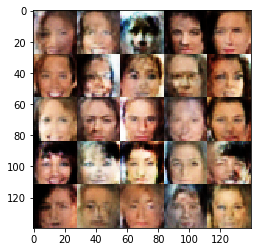

Epoch 1/1 Discriminator Loss-0.0366 Generator Loss1.3104
Epoch 1/1 Discriminator Loss1.9071 Generator Loss0.0586
Epoch 1/1 Discriminator Loss1.3726 Generator Loss0.0899
Epoch 1/1 Discriminator Loss0.8517 Generator Loss1.6532
Epoch 1/1 Discriminator Loss1.6318 Generator Loss0.0763
Epoch 1/1 Discriminator Loss0.0629 Generator Loss1.8175
Epoch 1/1 Discriminator Loss0.5936 Generator Loss0.7413
Epoch 1/1 Discriminator Loss-0.4001 Generator Loss1.9037
Epoch 1/1 Discriminator Loss-0.5182 Generator Loss1.8723
Epoch 1/1 Discriminator Loss0.9930 Generator Loss0.2995


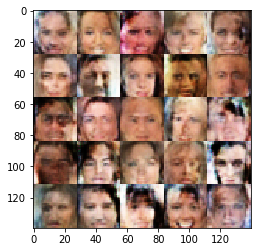

Epoch 1/1 Discriminator Loss0.0632 Generator Loss2.4422
Epoch 1/1 Discriminator Loss-0.8111 Generator Loss2.0444
Epoch 1/1 Discriminator Loss1.4793 Generator Loss0.3203
Epoch 1/1 Discriminator Loss-1.0553 Generator Loss4.5247
Epoch 1/1 Discriminator Loss-0.5350 Generator Loss5.2207
Epoch 1/1 Discriminator Loss-0.0020 Generator Loss1.6739
Epoch 1/1 Discriminator Loss1.1893 Generator Loss0.2349
Epoch 1/1 Discriminator Loss1.4325 Generator Loss2.7874
Epoch 1/1 Discriminator Loss-0.0452 Generator Loss3.9475
Epoch 1/1 Discriminator Loss-0.9015 Generator Loss5.8994


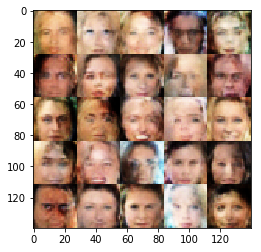

Epoch 1/1 Discriminator Loss2.7587 Generator Loss0.0788
Epoch 1/1 Discriminator Loss3.4641 Generator Loss5.2018
Epoch 1/1 Discriminator Loss0.0170 Generator Loss2.5459
Epoch 1/1 Discriminator Loss2.6170 Generator Loss0.0818
Epoch 1/1 Discriminator Loss1.3511 Generator Loss0.1004
Epoch 1/1 Discriminator Loss0.4107 Generator Loss1.4551
Epoch 1/1 Discriminator Loss-0.1017 Generator Loss1.1322
Epoch 1/1 Discriminator Loss0.5893 Generator Loss1.6559
Epoch 1/1 Discriminator Loss1.3345 Generator Loss0.1693
Epoch 1/1 Discriminator Loss1.2895 Generator Loss1.7287


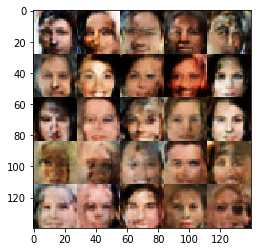

Epoch 1/1 Discriminator Loss2.9489 Generator Loss0.1045
Epoch 1/1 Discriminator Loss-0.1850 Generator Loss1.8388
Epoch 1/1 Discriminator Loss-0.3898 Generator Loss2.5962
Epoch 1/1 Discriminator Loss1.4934 Generator Loss0.1694
Epoch 1/1 Discriminator Loss2.8259 Generator Loss0.0343
Epoch 1/1 Discriminator Loss0.1964 Generator Loss0.6374
Epoch 1/1 Discriminator Loss-0.6396 Generator Loss3.4098
Epoch 1/1 Discriminator Loss0.3433 Generator Loss0.8653
Epoch 1/1 Discriminator Loss1.1466 Generator Loss0.3066
Epoch 1/1 Discriminator Loss1.6691 Generator Loss0.1268


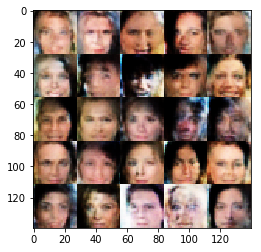

Epoch 1/1 Discriminator Loss0.9617 Generator Loss0.4202
Epoch 1/1 Discriminator Loss0.9046 Generator Loss0.1923
Epoch 1/1 Discriminator Loss1.2435 Generator Loss0.5000
Epoch 1/1 Discriminator Loss0.3060 Generator Loss1.0311
Epoch 1/1 Discriminator Loss0.0592 Generator Loss0.9817
Epoch 1/1 Discriminator Loss0.2300 Generator Loss0.8887
Epoch 1/1 Discriminator Loss-0.4245 Generator Loss1.6660
Epoch 1/1 Discriminator Loss-0.5474 Generator Loss3.5524
Epoch 1/1 Discriminator Loss-0.0760 Generator Loss1.0006
Epoch 1/1 Discriminator Loss-0.3722 Generator Loss2.8586


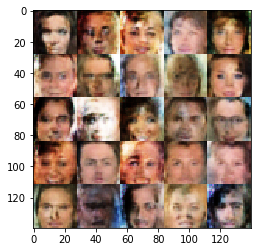

Epoch 1/1 Discriminator Loss0.7840 Generator Loss0.8012
Epoch 1/1 Discriminator Loss0.8580 Generator Loss0.7997
Epoch 1/1 Discriminator Loss3.4216 Generator Loss0.5808
Epoch 1/1 Discriminator Loss-0.3970 Generator Loss2.4466
Epoch 1/1 Discriminator Loss0.9101 Generator Loss4.2234
Epoch 1/1 Discriminator Loss1.0657 Generator Loss0.6079
Epoch 1/1 Discriminator Loss2.6603 Generator Loss0.6966
Epoch 1/1 Discriminator Loss1.1218 Generator Loss1.2525
Epoch 1/1 Discriminator Loss0.5906 Generator Loss1.2021
Epoch 1/1 Discriminator Loss-0.0211 Generator Loss1.6501


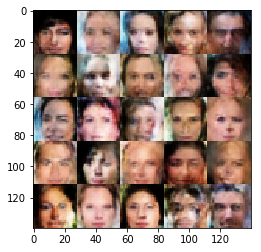

Epoch 1/1 Discriminator Loss0.9183 Generator Loss1.6465
Epoch 1/1 Discriminator Loss-0.1754 Generator Loss1.3674
Epoch 1/1 Discriminator Loss-0.3342 Generator Loss2.4047
Epoch 1/1 Discriminator Loss1.0535 Generator Loss0.7950
Epoch 1/1 Discriminator Loss0.7891 Generator Loss0.9871
Epoch 1/1 Discriminator Loss1.5153 Generator Loss0.0989
Epoch 1/1 Discriminator Loss1.1403 Generator Loss0.1513
Epoch 1/1 Discriminator Loss0.5053 Generator Loss1.1138
Epoch 1/1 Discriminator Loss0.5294 Generator Loss0.5951
Epoch 1/1 Discriminator Loss-0.6816 Generator Loss1.5801


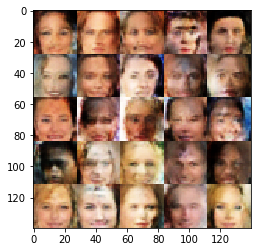

Epoch 1/1 Discriminator Loss0.7046 Generator Loss2.6861
Epoch 1/1 Discriminator Loss0.6446 Generator Loss0.9678
Epoch 1/1 Discriminator Loss0.5963 Generator Loss1.9327
Epoch 1/1 Discriminator Loss0.0014 Generator Loss3.6471
Epoch 1/1 Discriminator Loss2.4841 Generator Loss0.0568
Epoch 1/1 Discriminator Loss0.1037 Generator Loss2.7097
Epoch 1/1 Discriminator Loss0.9143 Generator Loss0.3692
Epoch 1/1 Discriminator Loss-0.3069 Generator Loss3.4204
Epoch 1/1 Discriminator Loss0.1651 Generator Loss2.0133
Epoch 1/1 Discriminator Loss-0.2675 Generator Loss2.7492


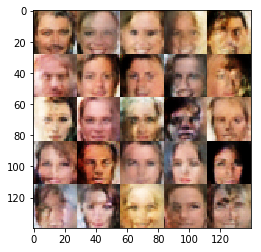

Epoch 1/1 Discriminator Loss-0.0022 Generator Loss1.3869
Epoch 1/1 Discriminator Loss0.8491 Generator Loss0.1738
Epoch 1/1 Discriminator Loss1.2675 Generator Loss0.7839
Epoch 1/1 Discriminator Loss1.5503 Generator Loss0.1447
Epoch 1/1 Discriminator Loss0.6075 Generator Loss1.2689
Epoch 1/1 Discriminator Loss-0.3119 Generator Loss0.9954
Epoch 1/1 Discriminator Loss-0.3251 Generator Loss1.7933
Epoch 1/1 Discriminator Loss-0.0316 Generator Loss0.2633
Epoch 1/1 Discriminator Loss0.5469 Generator Loss0.7230
Epoch 1/1 Discriminator Loss0.4695 Generator Loss0.5319


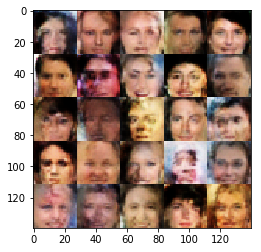

Epoch 1/1 Discriminator Loss0.3073 Generator Loss4.1371
Epoch 1/1 Discriminator Loss0.2140 Generator Loss1.1698
Epoch 1/1 Discriminator Loss-0.5456 Generator Loss2.3674
Epoch 1/1 Discriminator Loss0.9632 Generator Loss0.4508
Epoch 1/1 Discriminator Loss0.2354 Generator Loss0.6785
Epoch 1/1 Discriminator Loss3.0068 Generator Loss0.0293
Epoch 1/1 Discriminator Loss0.9166 Generator Loss1.6640
Epoch 1/1 Discriminator Loss0.8334 Generator Loss0.3199
Epoch 1/1 Discriminator Loss0.5312 Generator Loss0.6157
Epoch 1/1 Discriminator Loss-0.7007 Generator Loss4.0522


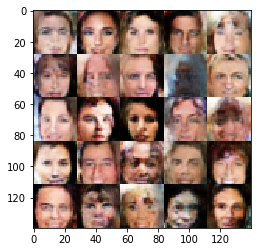

Epoch 1/1 Discriminator Loss3.1686 Generator Loss0.0246
Epoch 1/1 Discriminator Loss2.3213 Generator Loss0.1855
Epoch 1/1 Discriminator Loss0.5390 Generator Loss1.3217
Epoch 1/1 Discriminator Loss0.6853 Generator Loss0.5794
Epoch 1/1 Discriminator Loss0.7330 Generator Loss0.8463
Epoch 1/1 Discriminator Loss2.6433 Generator Loss0.0673
Epoch 1/1 Discriminator Loss1.3643 Generator Loss0.6341
Epoch 1/1 Discriminator Loss0.2603 Generator Loss0.9257
Epoch 1/1 Discriminator Loss0.4445 Generator Loss1.5164
Epoch 1/1 Discriminator Loss0.3468 Generator Loss0.5485


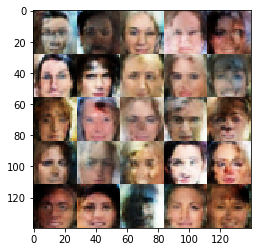

Epoch 1/1 Discriminator Loss0.2188 Generator Loss0.7556
Epoch 1/1 Discriminator Loss-0.5002 Generator Loss3.6644
Epoch 1/1 Discriminator Loss-0.1877 Generator Loss1.5889
Epoch 1/1 Discriminator Loss0.4351 Generator Loss0.6254
Epoch 1/1 Discriminator Loss0.9949 Generator Loss0.3230
Epoch 1/1 Discriminator Loss-0.0653 Generator Loss1.4962
Epoch 1/1 Discriminator Loss1.1281 Generator Loss0.3467
Epoch 1/1 Discriminator Loss-0.0995 Generator Loss0.8986
Epoch 1/1 Discriminator Loss1.5180 Generator Loss0.2169
Epoch 1/1 Discriminator Loss1.3891 Generator Loss0.2415


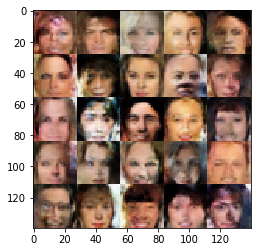

Epoch 1/1 Discriminator Loss0.0924 Generator Loss1.3115
Epoch 1/1 Discriminator Loss0.2426 Generator Loss0.7635
Epoch 1/1 Discriminator Loss0.1955 Generator Loss1.2235
Epoch 1/1 Discriminator Loss0.7103 Generator Loss0.6187
Epoch 1/1 Discriminator Loss0.7681 Generator Loss0.3157
Epoch 1/1 Discriminator Loss0.5625 Generator Loss4.7974
Epoch 1/1 Discriminator Loss2.8632 Generator Loss4.7415
Epoch 1/1 Discriminator Loss-0.2071 Generator Loss7.7047
Epoch 1/1 Discriminator Loss0.4988 Generator Loss2.0142
Epoch 1/1 Discriminator Loss0.6830 Generator Loss0.6360


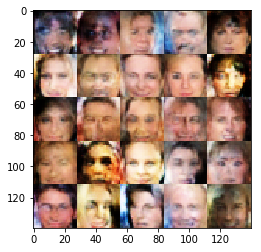

Epoch 1/1 Discriminator Loss0.3967 Generator Loss0.3711
Epoch 1/1 Discriminator Loss-0.2114 Generator Loss1.2732
Epoch 1/1 Discriminator Loss0.6589 Generator Loss0.9355
Epoch 1/1 Discriminator Loss-0.4416 Generator Loss2.2329
Epoch 1/1 Discriminator Loss0.6778 Generator Loss0.4385
Epoch 1/1 Discriminator Loss0.7982 Generator Loss1.4478
Epoch 1/1 Discriminator Loss0.6156 Generator Loss0.9292
Epoch 1/1 Discriminator Loss0.3700 Generator Loss0.4492
Epoch 1/1 Discriminator Loss0.2271 Generator Loss3.9807
Epoch 1/1 Discriminator Loss-0.3396 Generator Loss4.9296


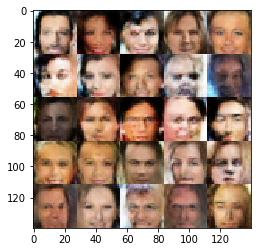

Epoch 1/1 Discriminator Loss1.0100 Generator Loss2.2244
Epoch 1/1 Discriminator Loss2.4268 Generator Loss0.0301
Epoch 1/1 Discriminator Loss0.1504 Generator Loss1.8967
Epoch 1/1 Discriminator Loss0.1306 Generator Loss1.1186
Epoch 1/1 Discriminator Loss1.0092 Generator Loss0.7276
Epoch 1/1 Discriminator Loss1.4685 Generator Loss0.6424
Epoch 1/1 Discriminator Loss0.0132 Generator Loss1.7528
Epoch 1/1 Discriminator Loss0.0509 Generator Loss0.8016
Epoch 1/1 Discriminator Loss0.4162 Generator Loss2.2614
Epoch 1/1 Discriminator Loss2.3941 Generator Loss0.0785


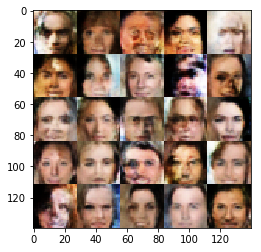

Epoch 1/1 Discriminator Loss1.5086 Generator Loss0.2937
Epoch 1/1 Discriminator Loss2.2022 Generator Loss0.1093
Epoch 1/1 Discriminator Loss0.7452 Generator Loss0.6470
Epoch 1/1 Discriminator Loss1.4220 Generator Loss0.3040
Epoch 1/1 Discriminator Loss0.8236 Generator Loss0.3535
Epoch 1/1 Discriminator Loss-0.0865 Generator Loss2.9985
Epoch 1/1 Discriminator Loss0.7995 Generator Loss2.9617
Epoch 1/1 Discriminator Loss0.4439 Generator Loss0.4092
Epoch 1/1 Discriminator Loss0.5108 Generator Loss1.9677
Epoch 1/1 Discriminator Loss2.5163 Generator Loss3.9321


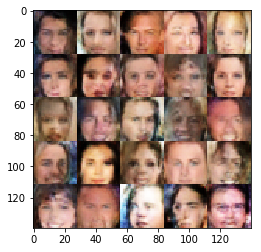

Epoch 1/1 Discriminator Loss1.1865 Generator Loss0.4616
Epoch 1/1 Discriminator Loss0.5029 Generator Loss0.8179
Epoch 1/1 Discriminator Loss0.7475 Generator Loss1.6184
Epoch 1/1 Discriminator Loss0.5865 Generator Loss0.6947
Epoch 1/1 Discriminator Loss0.5279 Generator Loss1.9425
Epoch 1/1 Discriminator Loss0.8035 Generator Loss0.3607
Epoch 1/1 Discriminator Loss0.9750 Generator Loss0.5138
Epoch 1/1 Discriminator Loss0.3708 Generator Loss1.5783
Epoch 1/1 Discriminator Loss0.7025 Generator Loss0.5087
Epoch 1/1 Discriminator Loss0.0829 Generator Loss2.1697


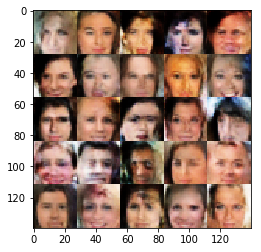

Epoch 1/1 Discriminator Loss0.2435 Generator Loss0.7044
Epoch 1/1 Discriminator Loss2.1845 Generator Loss0.1290
Epoch 1/1 Discriminator Loss0.9599 Generator Loss2.4769
Epoch 1/1 Discriminator Loss0.8082 Generator Loss0.6730
Epoch 1/1 Discriminator Loss0.2204 Generator Loss1.8341
Epoch 1/1 Discriminator Loss1.2516 Generator Loss1.4423
Epoch 1/1 Discriminator Loss0.4510 Generator Loss3.9077
Epoch 1/1 Discriminator Loss-0.0026 Generator Loss1.0478
Epoch 1/1 Discriminator Loss0.5267 Generator Loss0.7536
Epoch 1/1 Discriminator Loss1.2771 Generator Loss0.3859


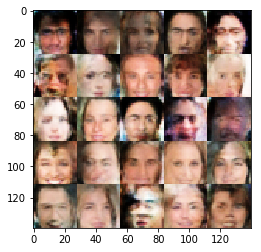

Epoch 1/1 Discriminator Loss-0.3730 Generator Loss1.5450
Epoch 1/1 Discriminator Loss1.6727 Generator Loss1.5862
Epoch 1/1 Discriminator Loss0.2650 Generator Loss0.8815
Epoch 1/1 Discriminator Loss-0.7719 Generator Loss4.7263
Epoch 1/1 Discriminator Loss2.3304 Generator Loss0.4215
Epoch 1/1 Discriminator Loss0.4837 Generator Loss0.6478
Epoch 1/1 Discriminator Loss1.6169 Generator Loss0.3717
Epoch 1/1 Discriminator Loss0.0282 Generator Loss1.7204
Epoch 1/1 Discriminator Loss0.9423 Generator Loss0.4127
Epoch 1/1 Discriminator Loss1.3960 Generator Loss0.1564


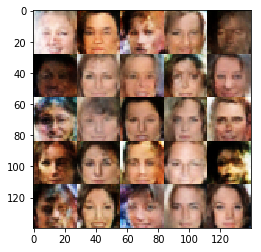

Epoch 1/1 Discriminator Loss2.6797 Generator Loss0.0375
Epoch 1/1 Discriminator Loss0.1493 Generator Loss1.7115
Epoch 1/1 Discriminator Loss0.5843 Generator Loss0.7423
Epoch 1/1 Discriminator Loss0.6008 Generator Loss0.9023
Epoch 1/1 Discriminator Loss-0.4520 Generator Loss1.5584
Epoch 1/1 Discriminator Loss1.1839 Generator Loss0.5153
Epoch 1/1 Discriminator Loss0.4850 Generator Loss1.0916
Epoch 1/1 Discriminator Loss1.1666 Generator Loss0.6591
Epoch 1/1 Discriminator Loss0.3184 Generator Loss0.3618
Epoch 1/1 Discriminator Loss0.6931 Generator Loss0.2886


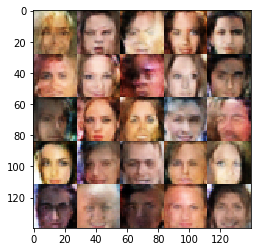

Epoch 1/1 Discriminator Loss0.7543 Generator Loss0.6368
Epoch 1/1 Discriminator Loss1.8307 Generator Loss0.1312
Epoch 1/1 Discriminator Loss2.0560 Generator Loss0.1929
Epoch 1/1 Discriminator Loss0.7116 Generator Loss0.7644
Epoch 1/1 Discriminator Loss0.0112 Generator Loss1.5375
Epoch 1/1 Discriminator Loss-0.1355 Generator Loss0.7466
Epoch 1/1 Discriminator Loss1.4775 Generator Loss0.7195
Epoch 1/1 Discriminator Loss-0.0742 Generator Loss2.2611
Epoch 1/1 Discriminator Loss-0.1300 Generator Loss2.7233
Epoch 1/1 Discriminator Loss2.7868 Generator Loss0.0272


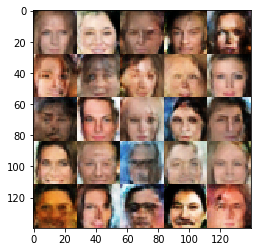

Epoch 1/1 Discriminator Loss2.1606 Generator Loss0.0516
Epoch 1/1 Discriminator Loss0.2502 Generator Loss0.9109
Epoch 1/1 Discriminator Loss0.5634 Generator Loss0.8462
Epoch 1/1 Discriminator Loss-0.0976 Generator Loss2.7616
Epoch 1/1 Discriminator Loss0.8496 Generator Loss0.7877
Epoch 1/1 Discriminator Loss-0.2486 Generator Loss2.5640
Epoch 1/1 Discriminator Loss2.6618 Generator Loss1.4168
Epoch 1/1 Discriminator Loss1.3920 Generator Loss0.1674
Epoch 1/1 Discriminator Loss-0.6118 Generator Loss2.3246
Epoch 1/1 Discriminator Loss0.1433 Generator Loss1.1513


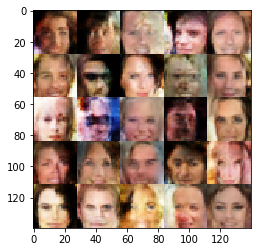

Epoch 1/1 Discriminator Loss0.4275 Generator Loss1.5998
Epoch 1/1 Discriminator Loss-0.5972 Generator Loss6.1283
Epoch 1/1 Discriminator Loss1.1309 Generator Loss0.1155
Epoch 1/1 Discriminator Loss1.5937 Generator Loss0.5810
Epoch 1/1 Discriminator Loss1.6260 Generator Loss0.2779
Epoch 1/1 Discriminator Loss1.1338 Generator Loss0.5932
Epoch 1/1 Discriminator Loss1.2784 Generator Loss0.8262
Epoch 1/1 Discriminator Loss1.0548 Generator Loss0.3049
Epoch 1/1 Discriminator Loss0.5738 Generator Loss0.7429
Epoch 1/1 Discriminator Loss1.0562 Generator Loss1.1600


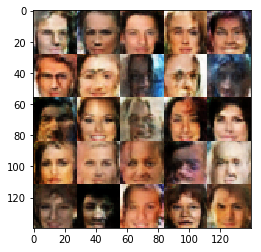

Epoch 1/1 Discriminator Loss-0.2042 Generator Loss1.1795
Epoch 1/1 Discriminator Loss0.3887 Generator Loss2.2109
Epoch 1/1 Discriminator Loss-0.2455 Generator Loss3.1696
Epoch 1/1 Discriminator Loss0.8727 Generator Loss0.5261
Epoch 1/1 Discriminator Loss0.2014 Generator Loss1.1872
Epoch 1/1 Discriminator Loss0.9534 Generator Loss0.3685
Epoch 1/1 Discriminator Loss0.3532 Generator Loss1.1033
Epoch 1/1 Discriminator Loss-0.1509 Generator Loss3.9415
Epoch 1/1 Discriminator Loss0.2049 Generator Loss2.1192
Epoch 1/1 Discriminator Loss1.4357 Generator Loss0.1205


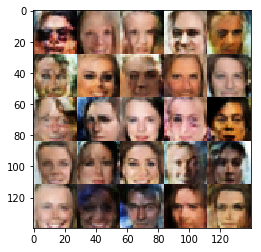

Epoch 1/1 Discriminator Loss0.4965 Generator Loss1.0140
Epoch 1/1 Discriminator Loss1.2780 Generator Loss0.1278
Epoch 1/1 Discriminator Loss1.7083 Generator Loss0.0609
Epoch 1/1 Discriminator Loss0.7243 Generator Loss1.0174
Epoch 1/1 Discriminator Loss0.3749 Generator Loss1.6760
Epoch 1/1 Discriminator Loss1.3694 Generator Loss0.7303
Epoch 1/1 Discriminator Loss1.3586 Generator Loss0.2343
Epoch 1/1 Discriminator Loss0.4844 Generator Loss1.3681
Epoch 1/1 Discriminator Loss0.6098 Generator Loss1.0248
Epoch 1/1 Discriminator Loss1.5988 Generator Loss0.2428


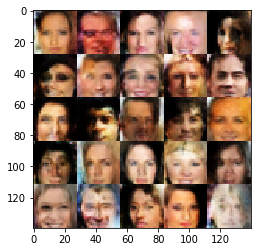

Epoch 1/1 Discriminator Loss0.1424 Generator Loss0.8615
Epoch 1/1 Discriminator Loss0.2821 Generator Loss1.2944
Epoch 1/1 Discriminator Loss1.0955 Generator Loss0.4008
Epoch 1/1 Discriminator Loss-0.4857 Generator Loss4.0439
Epoch 1/1 Discriminator Loss1.5862 Generator Loss0.1158
Epoch 1/1 Discriminator Loss1.0163 Generator Loss0.4511
Epoch 1/1 Discriminator Loss-0.0262 Generator Loss1.9198
Epoch 1/1 Discriminator Loss0.8779 Generator Loss0.6448
Epoch 1/1 Discriminator Loss0.7824 Generator Loss0.6267
Epoch 1/1 Discriminator Loss1.1862 Generator Loss0.4781


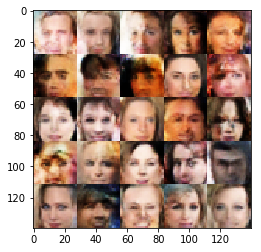

Epoch 1/1 Discriminator Loss1.5401 Generator Loss0.2328
Epoch 1/1 Discriminator Loss0.2344 Generator Loss0.9758
Epoch 1/1 Discriminator Loss0.9161 Generator Loss0.6843
Epoch 1/1 Discriminator Loss0.8291 Generator Loss0.5690
Epoch 1/1 Discriminator Loss1.0674 Generator Loss0.6705
Epoch 1/1 Discriminator Loss0.7414 Generator Loss1.3011
Epoch 1/1 Discriminator Loss1.3262 Generator Loss0.3671
Epoch 1/1 Discriminator Loss1.4110 Generator Loss0.6275
Epoch 1/1 Discriminator Loss0.8998 Generator Loss0.4080
Epoch 1/1 Discriminator Loss0.6918 Generator Loss0.9871


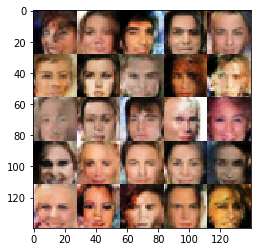

Epoch 1/1 Discriminator Loss1.6835 Generator Loss1.8833
Epoch 1/1 Discriminator Loss0.8726 Generator Loss0.4684
Epoch 1/1 Discriminator Loss1.0592 Generator Loss0.4694
Epoch 1/1 Discriminator Loss0.4653 Generator Loss0.7179
Epoch 1/1 Discriminator Loss0.4732 Generator Loss2.7542
Epoch 1/1 Discriminator Loss1.1255 Generator Loss0.8485
Epoch 1/1 Discriminator Loss2.1774 Generator Loss0.2190
Epoch 1/1 Discriminator Loss1.1569 Generator Loss0.6567
Epoch 1/1 Discriminator Loss1.5744 Generator Loss0.1622
Epoch 1/1 Discriminator Loss0.3206 Generator Loss0.9893


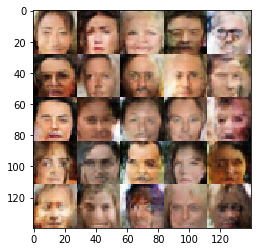

Epoch 1/1 Discriminator Loss1.2505 Generator Loss1.1019
Epoch 1/1 Discriminator Loss1.7461 Generator Loss0.2790
Epoch 1/1 Discriminator Loss1.2800 Generator Loss0.6422
Epoch 1/1 Discriminator Loss0.5952 Generator Loss0.9579
Epoch 1/1 Discriminator Loss0.8861 Generator Loss1.1660
Epoch 1/1 Discriminator Loss0.8691 Generator Loss0.6885
Epoch 1/1 Discriminator Loss1.6880 Generator Loss0.2782
Epoch 1/1 Discriminator Loss1.1831 Generator Loss0.3593
Epoch 1/1 Discriminator Loss6.4526 Generator Loss0.0039
Epoch 1/1 Discriminator Loss0.8600 Generator Loss0.4402


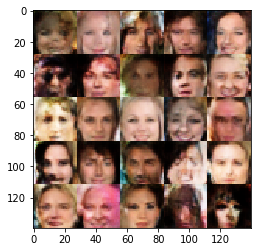

Epoch 1/1 Discriminator Loss0.4965 Generator Loss0.7346
Epoch 1/1 Discriminator Loss1.6991 Generator Loss0.1887
Epoch 1/1 Discriminator Loss1.4225 Generator Loss0.2455
Epoch 1/1 Discriminator Loss1.8651 Generator Loss0.3350
Epoch 1/1 Discriminator Loss0.2365 Generator Loss0.6054
Epoch 1/1 Discriminator Loss0.5872 Generator Loss1.1283
Epoch 1/1 Discriminator Loss0.9989 Generator Loss0.3751
Epoch 1/1 Discriminator Loss0.5147 Generator Loss1.5085
Epoch 1/1 Discriminator Loss1.4453 Generator Loss1.7635
Epoch 1/1 Discriminator Loss1.1164 Generator Loss1.4055


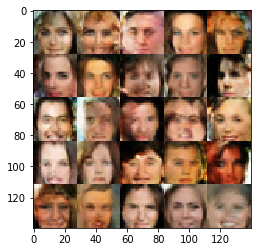

Epoch 1/1 Discriminator Loss0.8775 Generator Loss1.9489
Epoch 1/1 Discriminator Loss0.3170 Generator Loss1.1730
Epoch 1/1 Discriminator Loss0.5467 Generator Loss0.5039
Epoch 1/1 Discriminator Loss-0.0334 Generator Loss4.9677
Epoch 1/1 Discriminator Loss0.5481 Generator Loss4.0143
Epoch 1/1 Discriminator Loss0.6297 Generator Loss2.1762
Epoch 1/1 Discriminator Loss-0.4899 Generator Loss4.2791
Epoch 1/1 Discriminator Loss0.1994 Generator Loss1.0775
Epoch 1/1 Discriminator Loss1.1819 Generator Loss0.2728
Epoch 1/1 Discriminator Loss0.4701 Generator Loss0.9091


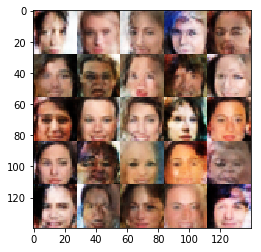

Epoch 1/1 Discriminator Loss0.6258 Generator Loss0.6983
Epoch 1/1 Discriminator Loss2.7838 Generator Loss0.1202
Epoch 1/1 Discriminator Loss0.7793 Generator Loss1.3530
Epoch 1/1 Discriminator Loss0.2473 Generator Loss1.0487
Epoch 1/1 Discriminator Loss1.0574 Generator Loss0.7963
Epoch 1/1 Discriminator Loss1.6121 Generator Loss0.7558
Epoch 1/1 Discriminator Loss0.4192 Generator Loss0.9548
Epoch 1/1 Discriminator Loss5.3403 Generator Loss3.4491
Epoch 1/1 Discriminator Loss2.0110 Generator Loss0.1758
Epoch 1/1 Discriminator Loss1.1946 Generator Loss0.7389


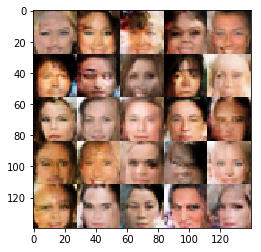

In [ ]:
batch_size = 32
z_dim = 200
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.